# McLean's Method

We have enough background now to begin a look at McLean's technique for estimating indoor model flight time. In this section, we will work through his development and see what we can produce using Python code.

Doug starts off his analysis with a simple assumption. The total flight time is a function of the energy available in the rubber motor divided by the power needed to maintain level flight.

\begin{equation}
t = \eta_{av} E / P
\end{equation}

In this equation, $\eta_{av}$ is a term related to the efficiency of the propeller. McLean defines it as follows:
    
\begin{equation}
\eta_{av} = F \eta_p
\end{equation}
    
$\eta_p$ is the theoretical propeller efficiency, **F** is a fudge factor derived from a study of actual model flight times.

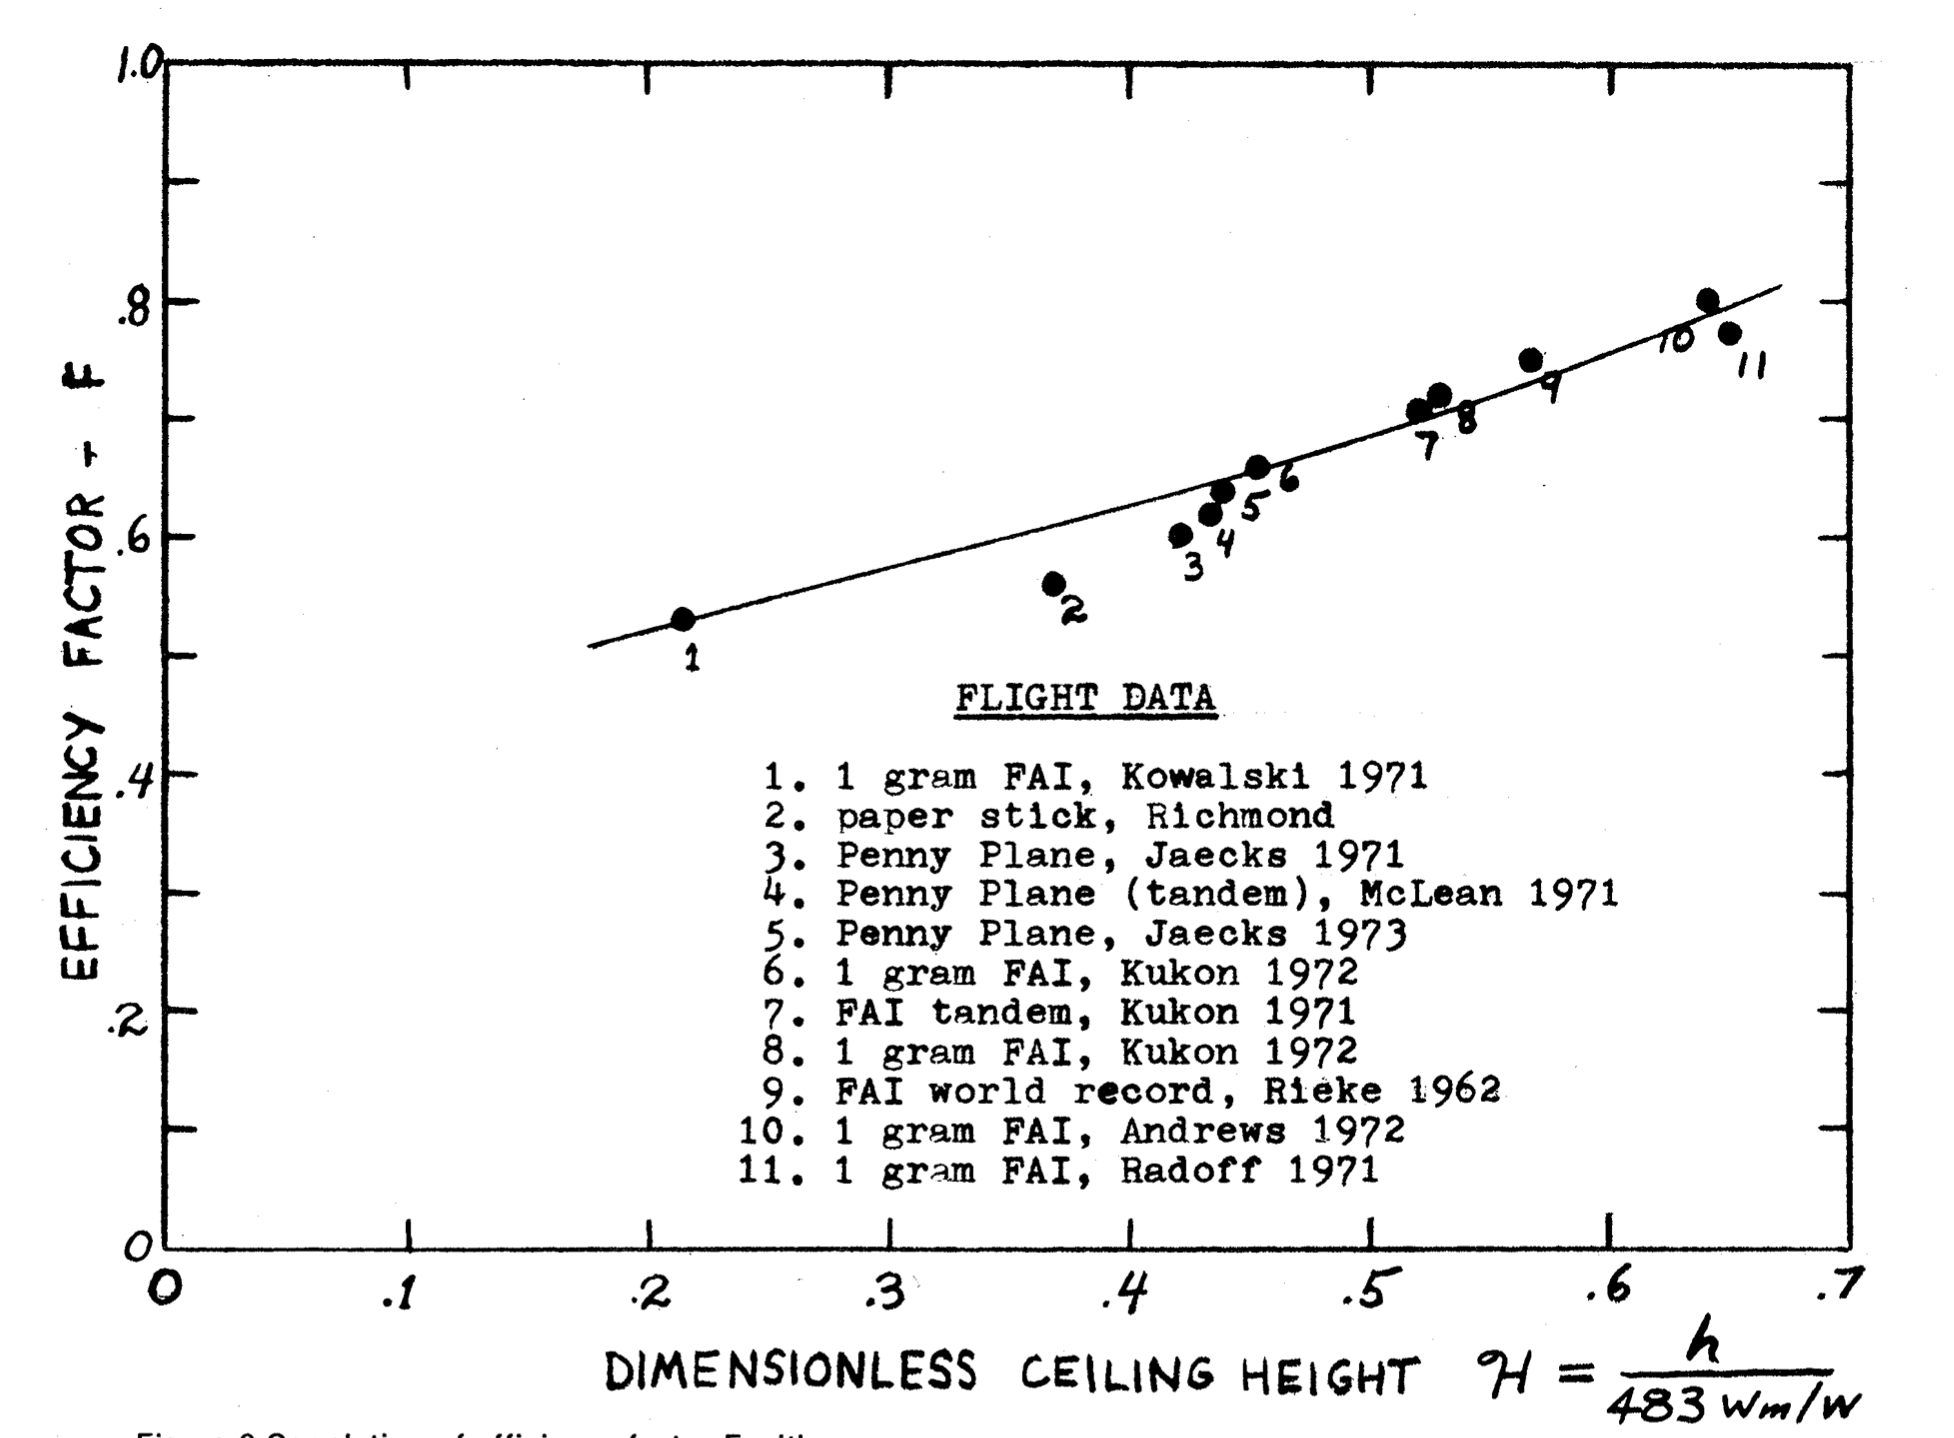

In [8]:
from IPython.display import Image
Image(filename="../../assets/images/mclean-efficiency-factor.png")

Let's load the digitized data from this graph and see how it looks:

In [9]:
import mmtime_helper
from mmtime.utils import get_points, show_curve, fit_curve

import os
from pathlib import Path
projdir = Path('/Users/rblack/_dev/nffs-symposium/live-2022')
datadir = projdir / 'mmtime' / 'data'

In [10]:
F_csv = datadir / 'efficiency-factor.csv'
F_x, F_y = get_points(F_csv)
fit_F = fit_curve(F_x, F_y)

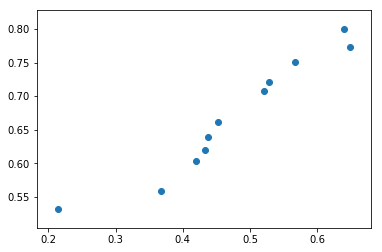

In [11]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

x = np.linspace(0,0.8,50)
raw_cl = fit_F(x)
smooth_F = savgol_filter(raw_cl, 21, 2)

#plt.plot(x,smooth_F, color='green')
plt.scatter(F_x, F_y)
plt.show()

The following code will generate a least-squares linear fit through these points. Note that this is not the same line as shown on McLean's graph!

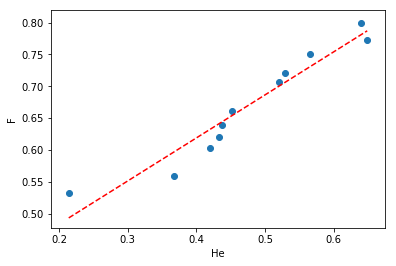

In [17]:
from scipy.optimize import curve_fit
from numpy import arange

def objective(x, a, b):
    return a * x + b

x_line = np.linspace(min(F_x), max(F_x), 2)
popt, _ = curve_fit(objective, F_x, F_y)
a, b = popt
y_line = objective(x_line, a, b)
plt.plot(x_line, y_line, '--', color='red')
plt.xlabel("He")
plt.ylabel("F")
plt.scatter(F_x, F_y)
plt.show()

Unfortunately, at the time this graph was developed the A6 class did not exist, so we have to find a place for our type of model. From the site data for the Kibby Dome, we can calculate the Dimensionless Ceiling Height value from McLean's formula:

In [ ]:
import pint
u = pint.UnitRegistry()

In [15]:
ceiling_height = 147 * u.feet
site_elevation = 2347 * u.feet
motor_weight = 0.86 * u.grams
model_weight = 2.06 * u.grams
const = 483 * u.feet

H_e = ceiling_height/(const * motor_weight / model_weight)
H_e

0.7290192113245703 <Unit('dimensionless')>

This number is off the current chart, but using the linear fit the data we can extrapolate and find a proper value for the fudge factor.

## Available Energy

To determine the amount of energy available in a flight, McLean turned to an an article by Max Hacklinger {cite}`hacklinger`. Hacklinger conducted both experimental and theoretical research into indoor model flight and determined that the energy available in indoor rubber motors was approximately just a function of motor weight. He came up with this equation:

\begin{equation}
E = k_m w_m
\end{equation}

Where:

- k_m is a constant = 900 meters
- $w_m$ is the motor weight

Gary Hodson's record setting flight of 10 minutes, 18 seconds, was made in 2003 at the Kibby Dome. ON that flight the motor weight was 0.84 grams. Let's see how much energy was available on that flight:

In [6]:
import pint
u = pint.UnitRegistry()

w_m = 0.86 * u.gram
k_m = 900 * u.meters
E = k_m * w_m

print(E)

774.0 gram * meter


In [7]:
E.to('ft * pound')

5.598352720836459 <Unit('foot * pound')>

That is a lot of energy for such a light model. If we really could convert all of that into flight time, we would be making extremely long flights. Unfortunately, we lose a lot of that power due to a number of inefficiencies in our designs.

The total energy in a system is constant. That energy can be converted from one form to another. The kinetic energy of an object is defines as
\begin{equation}
E_k = \frac{1}{2}m V^2
\end{equation}

If the Wart flew at 2 miles per hour for 618 seconds, the kinetic energy burned would be 

In [61]:
E_k = 0.5 * 2.06 * u.grams/u.gravity * (2 * u.miles/u.hour)**2
E_k.to('ft*pound')

0.0006072794793764947 <Unit('foot * pound')>

## Slusarczy's Max Turn Calculator

In [35]:
loop_weight = 1.4 * u.grams
loop_length = 14 * u.inches
K = 8.5 * u.ounces ** 0.5 /u.inches ** 1.5 

In [36]:
N_max = K * loop_length / (loop_weight/loop_length)**0.5  
N_max.to_base_units()

2003.6406787972865 <Unit('dimensionless')>

In [37]:
K.to('grams**0.5/inches**1.5')

45.25762969689476 <Unit('gram ** 0.5 / inch ** 1.5')>

## Level Flight Power

The next term we will consider is the power required to maintain level flight. McLean used a simple model for this part. Basically, his technique involved balancing the aerodynamic forces produced by the flying model so the model would remain level. From this, he predicted the model flight speed. I fond another article by Walter Erbach {cite}`erbach90` that used the same scheme to predict flight speed and power required. I decided to use Erbach's scheme for this calculation, since it seems more complete.